In [1]:
import numpy as np

from devito.logger import info
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import Model, PointSource, Receiver

from opescibench import LinePlotter

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:

class ModelBench(Model):
    """
    Physical model used for accuracy benchmarking,
    all is the same as a model except the critical dt
    made small enough to ignore
    time discretization errors
    """

    @property
    def critical_dt(self):
        """Critical computational time step value from the CFL condition."""
        # For a fixed time order this number goes down as the space order increases.
        #
        # The CFL condtion is then given by
        # dt <= coeff * h / (max(velocity))
        coeff = 0.38 if len(self.shape) == 3 else 0.42
        return .1

# Source function

The source time function is a Ricker Wavelet with peak frequency $f_0$ defined as:

\begin{equation}
     s(t) = (1 - 2 (\pi f_0 (t - \frac{2}{f_0}))^2) \text{exp}(-(\pi f_0 (t - \frac{2}{f_0}))^2)
\end{equation}

In [3]:
def source(time, f0):
    t00 = 4. / f0
    src = -200. * (time - t00) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t00) ** 2))
#     r = (np.pi * f0 * (time - 2./f0))
#     r1 = (np.pi * f0 * (time - 3./f0))
#     r2 = (np.pi * f0 * (time - 2.5/f0))
#     src = 10*(1-2.*r**2)*np.exp(-r**2)
#     src = (-200. * (time - 4./f0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - 4./f0) ** 2)) + 
#           350. * (time - 3./f0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - 3./f0) ** 2)) +
#           -500. * (time - 5./f0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - 5./f0) ** 2)) )
    return src

In [4]:
def G(time, source, r, dtloc):
    nt = len(time)
    G = np.zeros((nt,len(r)))
    for ix in range(len(r)):
        Gc = time * 0.       
        for it in range(0, nt): # Calculate Green's function
            if ((time[it] - r[ix]) > 1e-5):
                Gc[it] = (1. / (2 * np.pi)) \
                         * (1. / np.sqrt((time[it] ** 2) - (r[ix] ** 2)))
        G[:, ix]   = np.convolve(Gc, source * dtloc)[0:nt]
    return G

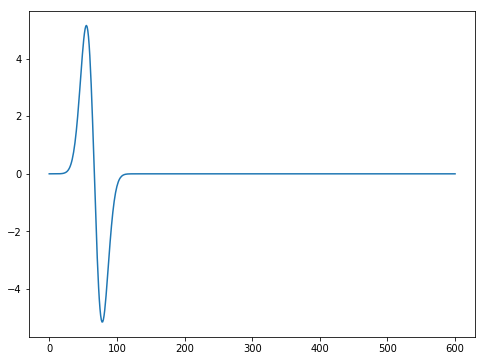

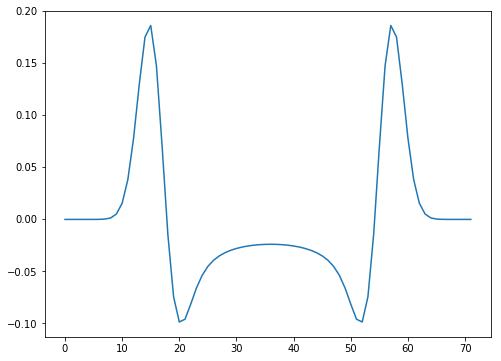

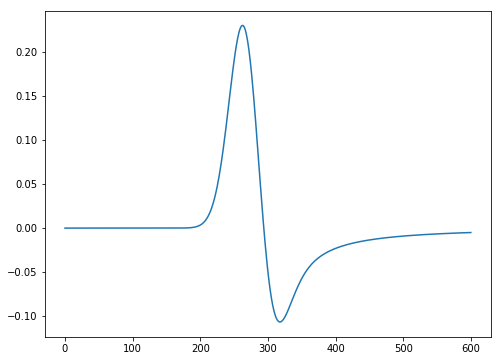

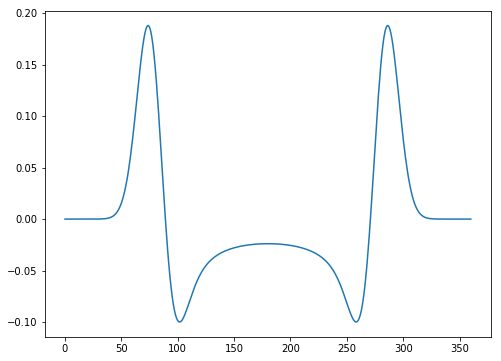

In [9]:
dt1 = 1.0
t0 = 0.0
tn = 600.
nt = int(1 + (tn-t0) / dt1)  # Number of timesteps
time1 = np.asarray([i*dt1 for i in range(nt)])
r = np.abs(np.arange(-360, 361))
r2 =  2.0*np.abs(np.arange(-180, 181))
analytical = G(time1, source(time1, 0.03), r, dt1)
analytical2 = G(time1, source(time1, 0.03), r2, dt1)
plt.figure()
plt.plot(source(time1, 0.06))
plt.show()
plt.figure()
plt.plot(analytical[336, 0:-1:int(10)])
plt.show()
plt.figure()
plt.plot(analytical[:, 500])
plt.show()
plt.figure()
plt.plot(analytical2[336, :])
plt.show()

In [ ]:
from sympy import Eq, solve
from devito import clear_cache, Operator, TimeFunction
sizes = dict({361 : 2, 181 : 4, 121 : 6, 91: 8}) #, 71 : 10}) # dict({601 : 2, 301 : 4, 151 : 8, 101 : 12})
orders = [2, 4, 6, 8 ,10]

errorl2 = np.zeros((4, len(orders)))
times = np.zeros((4, len(orders)))

cs = -1

for nn, h in sizes.items():
    cs += 1
    co = -1
    print("starting dx=%s with (%s, %s) grid points" % (h, nn, nn))
    for spc in orders:
        print("starting space order %s" % (spc))
        co += 1
        clear_cache()
        modelloc = ModelBench(vp=1., origin=(0., 0.), spacing=(h*1., h*1.), shape=(nn, nn), nbpml=0)
        dt = modelloc.critical_dt
        t0 = 0.0
        nt = 3360  # Number of timesteps
        time1 = np.asarray([i*dt for i in range(nt)]) # Discretized time axis
        src = PointSource(name='src', grid=modelloc.grid, ntime=nt, npoint=1)
        src.coordinates.data[0, :] = np.array(modelloc.domain_size) * .5
        src.data[:, 0] = source(time1, 0.03)

        # Create symbols for forward wavefield, source and receivers
        u = TimeFunction(name='u', grid=modelloc.grid, save=False,
                         time_order=2, space_order=spc)

        eqn = modelloc.m * u.dt2 - u.laplace
        stencil = [Eq(u.forward, solve(eqn, u.forward)[0])]
        sx = int((nn-1)/2)

        # Construct expression to inject source values
        src_term = [Eq(u.indexed[modelloc.grid.stepping_dim + 1, sx, sx], u.indexed[modelloc.grid.stepping_dim + 1, sx, sx]+
                       src.indexed[modelloc.grid.time_dim, src.indices[1]])]
        # Substitute spacing terms to reduce flops
        op = Operator(stencil + src_term, dse='noop', dle='noop')
        
        summary = op.apply (t_e=nt, dt=modelloc.critical_dt)
            
        errorl2[cs, co] = np.linalg.norm(analytical[336, 0:-1:int(h)]/np.linalg.norm(analytical[336, 0:-1:int(h)]) -
                                         u.data[nt%3, :-1, int((nn-1)/2)]/np.linalg.norm(u.data[nt%3, :-1, int((nn-1)/2)]))
        times[cs, co] = summary.timings['main']
        
        

In [ ]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')

with LinePlotter(figname='MyPrettyPicture.pdf', plotdir='./',  xlabel='error') as plot:
    for i in range(0, len(orders)):
        plot.add_line(list(errorl2[:, i]), list(times[:, i]), label=('order %s' % orders[i]),
                      annotations=[('dx = %s m' % (sc*.42)) for _, sc in sizes.items()][::-1], style=stylel[i])

plt.clf()
from IPython.display import IFrame
IFrame("MyPrettyPicture.pdf", width=600, height=600)

In [ ]:
print(times)

In [ ]:
print(errorl2)

In [ ]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')

with LinePlotter(figname='MyPrettyPicture3.pdf', plotdir='./',  xlabel='Grid size', ylabel = 'L2 error') as plot:
    for i in range(0, len(orders)):
        theory = [k**(orders[i]) for k in [2, 4, 6, 8, 10]][::-1]
        theory = [errorl2[-1,i]*th/theory[0] for th in theory]
        plot.add_line([sc*.42 for _, sc in sizes.items()][::-1], list(errorl2[::-1, i]), label=('order %s' % orders[i]),
                      annotations=[('dx = %s m' % (sc*.42)) for _, sc in sizes.items()][::-1], style=stylel[i])
#         plot.add_line([sc*.42 for _, sc in sizes.items()][::-1], theory,
#                       style='--')
plt.clf()
from IPython.display import IFrame
IFrame("MyPrettyPicture3.pdf", width=600, height=600)

In [47]:
h = 2
nn = 361
spc = 8
from devito import clear_cache, TimeFunction, Operator
from sympy import Eq, solve
clear_cache()
modelloc = ModelBench(vp=1., origin=(0., 0.), spacing=(1.0*h, 1.0*h), shape=(nn, nn), nbpml=0)
dt = modelloc.critical_dt
t0 = 0.0
nt = 3360  # Number of timesteps
time1 = np.asarray([i*dt for i in range(nt)]) # Discretized time axis
src = PointSource(name='src', grid=modelloc.grid, ntime=nt, npoint=1)
src.coordinates.data[0, :] = np.array(modelloc.domain_size) * .5
src.data[:, 0] = source(time1, 0.03)

# Create symbols for forward wavefield, source and receivers
u = TimeFunction(name='u', grid=modelloc.grid, save=False,
                 time_order=2, space_order=spc)

eqn = modelloc.m * u.dt2 - u.laplace
stencil = [Eq(u.forward, solve(eqn, u.forward,  rational=False, simplify=False)[0])]
sx = int((nn-1)/2)

# Construct expression to inject source values
src_term = [Eq(u.indexed[modelloc.grid.stepping_dim, sx, sx], u.indexed[modelloc.grid.stepping_dim + 1, sx, sx]+
               src.indexed[modelloc.grid.time_dim, src.indices[1]])]
# Substitute spacing terms to reduce flops
op = Operator(stencil + src_term, dse='noop', dle='noop')
summary = op.apply(dt=modelloc.critical_dt, t_e=nt)  

Allocating memory for damp ((361, 361))
Allocating memory for src_coords ((1, 2))
Allocating memory for src ((3360, 1))
DLE: ompize [elapsed: 0.00]
     [Total elapsed: 0.00 s]
Allocating memory for u ((3, 361, 361))
GNUCompiler: compiled /var/folders/mx/qs0dn9rx7zn6dz2zvwv7tkk00000gn/T/devito-12js6zxy/de905ab4b6adb84ca8d43264165d3ab69223e0e1.c [0.17 s]
Section section_1<3361,1> with OI=0.08 computed in 0.131 s [0.00 GFlops/s]
Section main<3361,357,357> with OI=11.12 computed in 8.341 s [4.67 GFlops/s, 0.05 GPts/s]


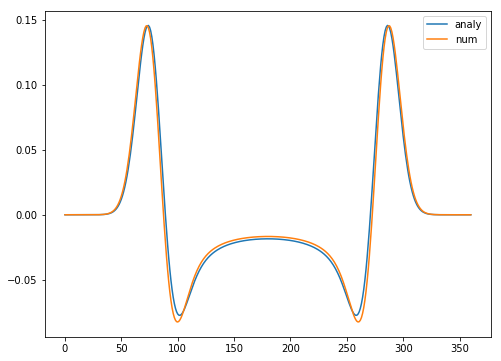

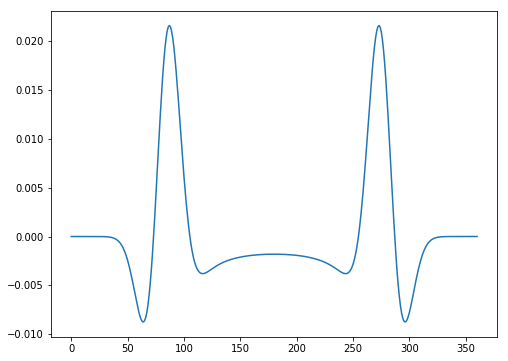

In [51]:
plt.figure()
plt.plot(analytical2[336, :]/np.linalg.norm(analytical2[336, :]), label="analy")
plt.plot(-u.data[(nt)%3, :, int((nn-1)/2)]/np.linalg.norm(u.data[(nt)%3, :, int((nn-1)/2)]), label="num")
plt.legend()
plt.show()
plt.figure()
plt.plot((analytical2[336, :]/np.linalg.norm(analytical2[336, :]) +
                                         u.data[(nt)%3, :, int((nn-1)/2)]/np.linalg.norm(u.data[(nt)%3, :, int((nn-1)/2)])))
plt.show() 

In [ ]:
np.linalg.norm(analytical[336, 0:-1:int(h)]/np.linalg.norm(analytical[336, 0:-1:int(h)]) -
                                         u.data[nt%3, :-1, int((nn-1)/2)]/np.linalg.norm(u.data[nt%3, :-1, int((nn-1)/2)]))

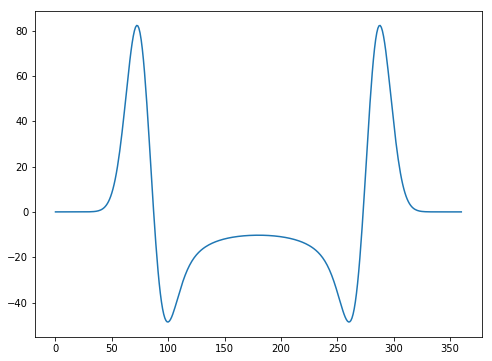

In [21]:
plt.figure()
plt.plot(u.data[(nt+1)%3, :, int((nn-1)/2)])
plt.show()